In [5]:
%matplotlib inline

In [6]:
import redqueen.opt_model as OM
import redqueen.opt_runs as OR
import redqueen.utils as RU
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import decorated_options as Deco
import multiprocessing as MP

In [7]:
sns.set_style(style='dark')
sns.set_palette('Set2')

In [8]:
from importlib import reload
reload(OM)
reload(OR)
reload(RU)

<module 'redqueen.utils' from '/Users/musically_ut/prog/work/RedQueen/redqueen/utils.py'>

In [9]:
OR.SimOpts(**{
        'src_id': 1,
        'q_vec': [],
        's': 1.0,
        'other_sources': [
            (
                'Poisson', 
                {
                    'src_id': 2,
                    'seed': 42,
                    'rates': 100
                }
            )
        ],
        'sink_ids': [1001],
        'end_time': 100.0,
        'edge_list': [(1, 1001), (2, 1001)]
    })

In [225]:
simOpts = OR.SimOpts.std_poisson(42, 1000)

# Exponential sampler

The output intensity is given by:

$$
u(t) = \exp( \underbrace{W_h \cdot h_j}_{\text{past}} - \overbrace{W_t (t - t_j)}^{\text{decay}} + \underbrace{b_t}_{\text{base}} )
$$

where $t_j$ is the last event before $t$.

It is simplified to the following in the code:

$$
u(t) = c \cdot e^{- W_t \cdot (t - t_j)}
$$

In [14]:
%run -i tpprl/exp_sampler.py

Testing the sampler.

In [8]:
def_plot_opts = Deco.Options(vt=0.5, 
                             wt=1.0,
                             bt=1.0,
                             init_h=0,
                             t_min=0,
                             t_max=10,
                             resolution=200)

@Deco.optioned()
def plot_lambda(vt, wt, bt, init_h, t_min, t_max, events, resolution):
    X = np.linspace(t_min, t_max, num=resolution)
    
    
    event_idx = 0
    c = np.exp(vt * init_h + bt)
    t0 = t_min
    
    # TODO: In the baseilne, shouldn't the t_0 still be updated to the latest event?
    Y1 = [c * np.exp(-wt * (x - t0)) for x in X]
    
    Y2 = [None] * len(X)
    for idx, x in enumerate(X):
        while event_idx < len(events) and events[event_idx][0] < x:
            c = np.exp(vt * events[event_idx][1] + bt)
            t0 = events[event_idx][0]
            event_idx += 1
            
        Y2[idx] = c * np.exp(-wt * (x - t0))
    
    plt.step(X, Y1, '--', label='Baseline')
    plt.step(X, Y2, '-', label='Correct')
    plt.vlines([x[0] for x in events], ymin=0, ymax=max(Y2), label='Events')
    plt.legend()
    return (X, Y1, Y2)

In [9]:
events = [(1, -8), (5, 5), (9, 0)]

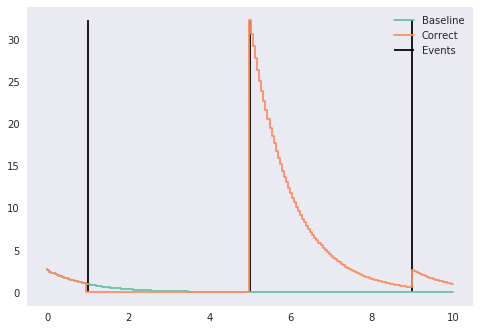

In [10]:
X, Y1, Y2 = plot_lambda(events=events, _opts=def_plot_opts)

In [11]:
sampler = ExpCDFSampler(_opts=def_plot_opts, seed=101 + 1279)

In [12]:
sampler.generate_sample()

0.6092880541958573

In [13]:
sampler.reset_only_sample(sampler.generate_sample())

0.98369540000156641

In [14]:
sampler.reset(1, -4, False)

0.9725887021550208

In [15]:
sampler.register_event(5, 0.5, False)

4.924794439657469

In [16]:
sampler.reset_only_sample(sampler.generate_sample())

4.9482122321618336

In [17]:
sampler.register_event(9, 0, False)

8.7893001591946209

In [18]:
sampler.reset_only_sample(sampler.generate_sample())

9.0386156318159898

In [19]:
sampler.generate_sample()

9.0386156318159898

## Tests

In [20]:
%%time
all_sim_events = []
processes = None
N = 10000
verbose = False

assert not verbose or (N < 10 and processes is not None), "Cannot have verbose output with these settings."

def worker_sampler(params):
    ii, sampler = params
    event_idx = 0
    next_sample = sampler.generate_sample()
    sim_events = []
        
    while next_sample < def_plot_opts.t_max or event_idx < len(events):
        while event_idx < len(events) and \
              events[event_idx][0] < next_sample:
            # print("Old = ", next_sample)
            old_sample = next_sample
            next_sample = sampler.register_event(events[event_idx][0], 
                                                 events[event_idx][1], 
                                                 False)
            if verbose:
                print("Eps = {}, Old = {}, Event = {}, Next = {}"
                      .format(ii, old_sample, events[event_idx], next_sample))
                
            event_idx += 1
            
        if next_sample > def_plot_opts.t_max:
            break
            
        if verbose:
            print("Final sample = {}".format(next_sample))                
        
        sim_events.append(next_sample)
        next_sample = sampler.reset_only_sample(next_sample)
    
    return sim_events
    

with MP.Pool(processes=processes) as pool:
    for sim_events in pool.map(worker_sampler,
                               [(ii, ExpCDFSampler(_opts=def_plot_opts, seed=101 + ii))
                                for ii in range(N)]):
        all_sim_events.append(sim_events)


CPU times: user 1.23 s, sys: 467 ms, total: 1.7 s
Wall time: 1.85 s


In [21]:
flat_events = [x for y in all_sim_events for x in y]

In [22]:
[x for x in flat_events if x < 0]

[]

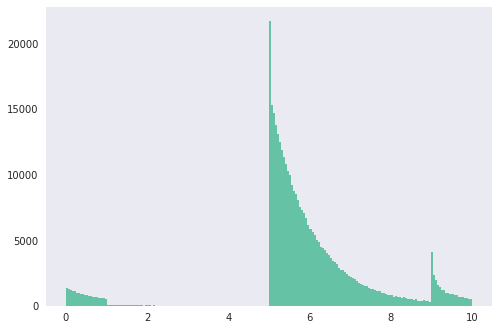

In [23]:
plt.hist(flat_events, bins=200);

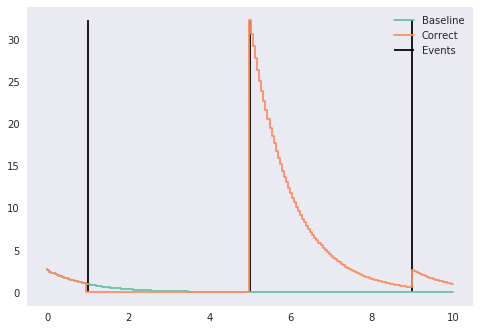

In [24]:
X, Y1, Y2 = plot_lambda(events=events, _opts=def_plot_opts)

In [26]:
len(all_sim_events)

10000

## ExpCDFBroadcaster

In [226]:
class ExpBroadcasterOld(OM.Broadcaster):
    
    @Deco.optioned()
    def __init__(self, src_id, seed, vt, wt, bt, init_h, t_min=0):
        super(ExpBroadcasterOld, self).__init__(src_id, seed)
        self.init = False
        self.vt = vt
        self.wt = wt
        self.bt = bt
        self.init_h = init_h
        self.exp_sampler = ExpCDFSampler(vt=vt, wt=wt, bt=bt,
                                         init_h=init_h, t_min=t_min, seed=seed)
        
    def get_next_interval(self, event):
        if not self.init:
            self.init = True
            # Nothing special to do for the first event.
            
        self.state.apply_event(event)
        
        if event is None:
            # This is the first event. Post immediately to join the party?
            # Or hold off?
            return self.exp_sampler.generate_sample()
        elif event.src_id == self.src_id:
            # We posted.
            hidden_state = self.exp_sampler.get_last_hidden_state()
            new_hidden_state = self.random_state.randn(*hidden_state.shape)
            self.exp_sampler.register_event(time=self.get_current_time(event), 
                                            new_h=hidden_state,
                                            own_event=True)
        else:
            # Have to update the hidden state and the t0 of our ExpSampler
            return None # Preserve the old time

In [227]:
OM.SimOpts.registerSource('ExpBroadcasterOld', ExpBroadcasterOld)

In [228]:
RS = np.random.RandomState(420)

simOpts = OM.SimOpts(
   src_id = 1,
   end_time = 100, # When the simulations stop
   q_vec = np.asarray([1.0, 1.0]), # Weights of followers
   s = 1.0, # Control parameter for RedQueen
   sink_ids = [1, 2],
   other_sources = [
      ('ExpBroadcasterOld', 
       {'src_id': 2,
        'seed': 42,
        'wt': 0.5,
        'init_h': 0.1 * RS.randn(10),
        'vt': 0.1 * RS.randn(10),
        'bt': 1.0,
       }
      ),
      ('Hawkes',
       {'src_id': 3,
        'seed': 43,
        'alpha': 0.01 * np.exp(RS.randn(10).dot(RS.randn(10))),
        'beta': 0.5,
        'l_0': np.exp(1.0)
       }
      )
   ],
   edge_list=[(1, 1), (1, 2), 
              (2, 1), (2, 2),
              (3, 1), (3, 2)]
)

In [30]:
mgr = simOpts.create_manager_with_opt(seed=6)

In [31]:
%%time
mgr.run_dynamic()

CPU times: user 153 ms, sys: 3.33 ms, total: 157 ms
Wall time: 150 ms


In [32]:
df = mgr.get_state().get_dataframe()

In [33]:
df.head()

,event_id,sink_id,src_id,t,time_delta
0,100,1,1,0.000000,0.000000
1,100,2,1,0.000000,0.000000
2,101,1,3,0.044966,0.044966
3,101,2,3,0.044966,0.044966
4,102,1,3,0.097634,0.052668


In [34]:
df.groupby('src_id').size()

src_id
1     614
2    1174
3     520
dtype: int64

# Reinf broadcaster

In [23]:
iterSession = tf.InteractiveSession()

In [96]:
iterSession.run(tf.one_hot([0,1], depth=1, dtype=tf.float32))

RuntimeError: Graph is finalized and cannot be modified.

In [97]:
input_dim = 1
hidden_dim = 16

class ReinfNetwork():
    def __init__(self, s_size, scope, trainer):
        with tf.variable_scope(scope):
            self.event_source = tf.placeholder(dtype=tf.int64, name='Event source', shape=[1])
            self.inp = tf.one_hot(indices=[self.event_source], depth=1, dtype=tf.float32)
            self.cell = tf.contrib.rnn.BasicRNNCell(hidden_dim)
            self.Wh = tf.get_variable('Wh', shape=)            

SyntaxError: invalid syntax (<ipython-input-97-5ada64ef1d8c>, line 10)

In [25]:
class Reinf(OM.Broadcaster):
    
    @Deco.optioned()
    def __init__(self, src_id, seed, hidden_dim):
        super(Reinf, self).__init__(src_id, seed)
        self.init = False
        
        self.Wh = tf.get_variable()
        
    def get_next_interval(self, event):
        if not self.init:
            # Create variables here?
            self.init = True
        
        self.state.apply_event(event)
        
        if event is None:
            # This is the first event. Post immediately to join the party?
            # Or hold off?
            return np.inf
        
        elif event.src_id == self.src_id:
            # We posted. Calculate reward.
            # We would never like to post now.
            return np.inf
        
        else:
            # Update our rate of posting.
            r_t = self.state.get_wall_rank(self.src_id, self.sink_ids,
                                           dict_form=False)
            # TODO: Magic.
            #  1 - Reward for this interval?
            #  2 - Sample the posting time again using inverse CDF
            #  3 - New sample is guaranteed to be closer to now than
            #      the original posting time.
            cur_time = event.cur_time
            t_delta_new = 10 # TODO: Take a new sample here.
            return cur_time + t_delta_new - self.last_self_event_time
        
    def train(self):
        """Will do RL here."""
        pass
            


In [26]:
mgr = simOpts.create_manager_with_broadcaster(Reinf(1, 100))

In [27]:
mgr.run_dynamic()

In [28]:
df = mgr.state.get_dataframe()

In [29]:
df.head()

,event_id,sink_id,src_id,t,time_delta
0,100,1001,2,0.004632,0.004632
1,101,1001,2,0.005062,0.000430
2,102,1001,2,0.005522,0.000461
3,103,1001,2,0.006952,0.001430
4,104,1001,2,0.009197,0.002245


# ExpTrainer

In [217]:
%run -i tpprl/exp_broadcaster.py
%run -i tpprl/exp_sampler.py

In [218]:
tf.reset_default_graph()

In [219]:
iterSession.close()

In [220]:
iterSession = tf.Session()

In [ ]:
%%time
hidden_dims = 10
num_other_broadcasters = 1
RS = np.random.RandomState(seed=42)

trainer_opts = Deco.Options(
    Wh=RS.randn(hidden_dims, hidden_dims) * 0.1 + np.diag(np.ones(hidden_dims)), # Careful initialization
    Wm=RS.randn(num_other_broadcasters + 1, hidden_dims),
    Wr=RS.randn(hidden_dims, 1),
    Wt=RS.randn(hidden_dims, 1),
    Bh=RS.randn(hidden_dims, 1),
    
    vt=RS.randn(hidden_dims, 1),
    wt=np.abs(RS.rand(1)),
    bt=RS.randn(1),
    
    init_h=RS.randn(hidden_dims),
    
    max_events=100,
    batch_size=10,
    
    learning_rate=0.1,
    clip_norm=1.0
)
sim_opts = OM.SimOpts(
    sink_ids=[1000],
    src_id=1,
    other_sources=[('Hawkes', {'src_id': 100, 'seed': 93})],
    end_time=100.0,
    q_vec=None,
    s=1.0,
    edge_list=None
)

trainer = ExpRecurrentTrainer(sim_opts=sim_opts, _opts=trainer_opts, sess=iterSession)

In [ ]:
%%time
trainer.initialize(finalize=False)

In [162]:
# trainer.restore(epoch_to_recover=1)

INFO:tensorflow:Restoring parameters from tpprl-log/tpprl.ckpt-1


In [ ]:
iterSession.run([trainer.tf_wt, trainer.tf_bt])

In [216]:
%%time
trainer.train_many(10)

Epoch 0, LL = -29.642, loss = 0.453, reward = -29.189, seeds = (42 -- 44)
Epoch 1, LL = -22.968, loss = 0.539, reward = -22.429, seeds = (44 -- 46)
Epoch 2, LL = -37.221, loss = 1.114, reward = -36.107, seeds = (46 -- 48)
Epoch 3, LL = -29.595, loss = 0.840, reward = -28.755, seeds = (48 -- 50)
Epoch 4, LL = -36.576, loss = 1.400, reward = -35.176, seeds = (50 -- 52)
Epoch 5, LL = -42.759, loss = 1.538, reward = -41.221, seeds = (52 -- 54)
Epoch 6, LL = -35.747, loss = 1.823, reward = -33.924, seeds = (54 -- 56)
Epoch 7, LL = -22.501, loss = 1.441, reward = -21.061, seeds = (56 -- 58)
Epoch 8, LL = -34.908, loss = 1.451, reward = -33.457, seeds = (58 -- 60)
Epoch 9, LL = -28.319, loss = 1.830, reward = -26.489, seeds = (60 -- 62)


In [20]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'ExpRecurrentTrainer/hidden_state/Wm:0' shape=(2, 10) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Wh:0' shape=(10, 10) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Wt:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Wr:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Bh:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/h:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/output/bt:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/output/vt:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/output/wt:0' shape=(1,) dtype=float32_ref>]

In [166]:
df = trainer.run_sim(10)
df2 = trainer.run_sim(11)
f_d = trainer.get_feed_dict([df, df2])

tpprl/exp_sampler.py:57: RuntimeWarning: divide by zero encountered in true_divide
  D = 1 + (self.w / self.c) * np.log(1 - self.u_unif)


In [107]:
trainer.reward_fn(df), trainer.reward_fn(df2)

(1518.9616195114122, 1560.8206297444681)

In [74]:
trainer.sess.run(trainer.tf_wt)

array([ 0.71217924], dtype=float32)

In [75]:
trainer.sess.run(trainer.loss, feed_dict=f_d)

array([ inf,  inf], dtype=float32)

In [76]:
trainer.sess.run(trainer.LL, feed_dict=f_d)

array([ -4.09034506e+25,  -1.37661263e+27], dtype=float32)

In [77]:
h_states, LL_log_terms, LL_int_terms, loss_terms = \
    trainer.sess.run([trainer.h_states, trainer.LL_log_terms, trainer.LL_int_terms, trainer.loss_terms],
                     feed_dict=f_d)

In [85]:
f_d[trainer.tf_batch_last_interval]

array([ 90.57601826,  96.81127148])

In [78]:
h_states

[array([[-0.9115566 ,  0.71723014, -0.97521561, -0.47082722, -0.10776117,
          0.91118366,  0.44068578, -0.83915508,  0.74536854, -0.05422911],
        [-0.84137094,  0.71049112, -0.96230608, -0.54134536,  0.07595625,
          0.84076971,  0.55810207, -0.81899536,  0.66369843,  0.19008458]], dtype=float32),
 array([[-0.99633706,  0.78127134, -0.96864825,  0.86236912, -0.25134704,
          0.99995434, -0.97176838, -0.99928141,  0.99447763, -0.35514545],
        [-0.99760336,  0.76176906, -0.97909141,  0.87795103, -0.31097731,
          0.99997282, -0.97431773, -0.99947488,  0.99549544, -0.35482129]], dtype=float32),
 array([[-0.96259546,  0.10328309, -0.33070633,  0.71082175,  0.52160001,
          0.99999905, -0.999695  , -0.99960703,  0.99258041, -0.68673784],
        [-0.92427891,  0.07617671, -0.10500666,  0.65498424,  0.62975359,
          0.99999803, -0.99956745, -0.99952984,  0.98923784, -0.50380194]], dtype=float32),
 array([[-0.942298  , -0.89893192,  0.86398196, -0.4926

In [79]:
np.hstack([x[:, np.newaxis] for x in LL_log_terms])

array([[ 0.        , -3.85976458, -4.83879995, -6.08512831, -0.61952037],
       [ 0.        , -3.73670936, -5.01473522, -5.43658209, -6.33867979]], dtype=float32)

In [80]:
np.hstack([x[:, np.newaxis] for x in LL_int_terms])

array([[ 0.0626863 ,  0.01171056,  0.00255716,  0.00132096,  0.75175852],
       [ 0.01133484,  0.0159338 ,  0.00085054,  0.00398099,  0.00091197]], dtype=float32)

In [81]:
np.hstack([x[:, np.newaxis] for x in loss_terms])

array([[  1.75098721e-02,   1.97943082e-04,   1.79153594e-05,
          2.38577945e-06,   2.03357533e-01],
       [  5.25153615e-03,   2.89334479e-04,   5.38948416e-06,
          1.16911715e-05,   1.31496267e-06]], dtype=float32)

In [82]:
LL_int_terms

[array([ 0.0626863 ,  0.01133484], dtype=float32),
 array([ 0.01171056,  0.0159338 ], dtype=float32),
 array([ 0.00255716,  0.00085054], dtype=float32),
 array([ 0.00132096,  0.00398099], dtype=float32),
 array([ 0.75175852,  0.00091197], dtype=float32)]

In [26]:
%%time
LL_grads = iterSession.run(trainer.LL_grads, feed_dict=f_d)
loss_grads = iterSession.run(trainer.loss_grads, feed_dict=f_d)

CPU times: user 671 ms, sys: 41 ms, total: 712 ms
Wall time: 717 ms


In [275]:
LL_grads

{<tf.Variable 'ExpRecurrentTrainer/hidden_state/Wh:0' shape=(10, 10) dtype=float32_ref>: [array([[ -2.99606800e+00,  -3.71909976e+00,   1.33702028e+00,
           -1.39037979e+00,   2.38318825e+00,   5.02713108e+00,
           -4.98379850e+00,  -5.02480364e+00,   5.00027657e+00,
           -4.75504494e+00],
         [ -4.26948833e+00,   6.26499414e-01,  -3.67279363e+00,
           -2.40540743e+00,   5.53412390e+00,   1.09491434e+01,
           -7.16436386e+00,  -1.08532867e+01,   1.05527220e+01,
           -7.23006105e+00],
         [  6.11900234e+00,  -2.49526954e+00,   5.35612297e+00,
           -2.09307718e+00,  -2.65487337e+00,  -8.32765388e+00,
            6.56142616e+00,   8.27307034e+00,  -8.13354778e+00,
            5.22924948e+00],
         [ -4.23263025e+00,   5.24473786e-01,  -2.38811493e+00,
            5.79427004e-01,   2.33740950e+00,   4.85080910e+00,
           -3.52857614e+00,  -4.82357693e+00,   4.70750713e+00,
           -3.39204454e+00],
         [ -5.24386501e+00, 

In [42]:
def check_good_grad(grad_dict):
    """Check whether the gradient has only finite values."""
    all_good = True
    for batch_grad in grad_dict.values():
        for x in batch_grad:
            # Unwrap gradient
            grad = x[0]
            
            # Handle IndexedSlicesValue named tuple
            if hasattr(grad, 'dense_shape'):
                y = np.zeros(grad.dense_shape)
                y[grad.indices] = grad.values
                grad = y
            all_good = all_good and np.all(np.isfinite(grad))
    return all_good


In [44]:
check_good_grad(LL_grads), check_good_grad(loss_grads)

(True, True)

In [214]:
true_grads = trainer.get_batch_grad([df, df2])

In [216]:
avg_grad_np = average_gradients([[(grad.astype(np.float32), var) for var, grad in x.items()] for x in true_grads])

In [217]:
avg_grad_tf = [(iterSession.run(grad, feed_dict=f_d), var) 
               for grad, var in trainer.avg_gradient]

In [218]:
tower_grad_tf = [{var: iterSession.run(grad, feed_dict=f_d)
                  for grad, var in trainer.tower_gradients[batch_idx]}
                 for batch_idx in range(trainer.batch_size)]

In [198]:
tower_grad_tf[1][trainer.tf_bt]

array([ 174637.484375], dtype=float32)